# Preface

<br>**Title:** PDAC Untargeted Metabolomics and Gut Barrier Project
<br>**File Name:** ML_PDAC_Control
<br>**Updated on:** 14 August 2025
<br>**Author:** Chek, Zi Yan Jane
<br>**Supervised by:** Dr. David Hughes and Dr. Neil Daniel

<br>**Procedures Covered:**
- Model Training (Standard Framework)
- Cross-Validation (CV)
- Model Evaluation
- Model Comparison

> **Note:** This script was developed by the author as part of a UCD academic research project under supervised guidance. The content is shared solely for evaluation, feedback, or academic review purposes. 
> Unauthorised distribution, reuse, or reproduction of the code or its components is not permitted without the author's written consent.

# Model Training, Validation and Evaluation

## Import Libraries

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

## Load Dataset

In [45]:
# Load data
df_mc = pd.read_csv("KNNImpute_MetabClinBatch_Data.csv")

### List of Clinical Columns

In [46]:
# List of clinical columns
clinical_cols = ['ID', 'Sex', 'Age', 'BMI', 'pT', 'pN', 'pM', 'Grade', 'Stage', 'OS (Months)', 'Cohort', 'Group', 'Batch', 'Label']
len(clinical_cols)

14

### List of Metabolite Columns

In [47]:
# List of metabolite columns
metabo_cols = df_mc.columns.difference(clinical_cols).tolist()
len(metabo_cols)

3644

In [48]:
# Load LASSO-selected metabolites
df_lasso_selected = pd.read_csv("LASSO_Selected_Metabolites.csv")
lasso_selected_features = df_lasso_selected['Metabolite'].tolist()

In [49]:
# Load HSIC LASSO-selected metabolites
df_hsiclasso_selected = pd.read_csv("HSICLasso_Selected_TopK_Metabolites.csv")
hsic_selected_features = df_hsiclasso_selected['Feature'].tolist()

## Train-Test Split

In [50]:
# Split df_mc to train (80%) and test (20%) sets
train_idx, test_idx = train_test_split(df_mc.index, test_size=0.2, stratify=df_mc['Label'], random_state=42)

In [51]:
# Subset both scaled and raw data
df_train = df_mc.loc[train_idx]
df_test = df_mc.loc[test_idx]

### Feature Matrix X and Label Vector y

In [52]:
# Extract feature matrix (metabolites only) and target labels
X_train = df_train[metabo_cols]
y_train = df_train['Label']

X_test = df_test[metabo_cols]
y_test = df_test['Label']

## Logistic Regression (Baseline Model)

### Using LASSO-Selected Features

In [53]:
X_train_lasso = X_train[lasso_selected_features]
X_test_lasso = X_test[lasso_selected_features]

In [54]:
# Train Logistic Regression model using LASSO selected features
lasso_logReg_model = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    penalty=None,  # No regularisation now, LASSO already selected features
    max_iter=10000,
    random_state=42
)
# Fit the model
lasso_logReg_model.fit(X_train_lasso, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42, solver='saga')

In [55]:
# Predict and evaluate
y_pred_lasso_lr = lasso_logReg_model.predict(X_test_lasso)
y_prob_lasso_lr = lasso_logReg_model.predict_proba(X_test_lasso)[:, 1]

print("Logistic Regression using LASSO-selected metabolites\n")
print("Classification Report:\n", classification_report(y_test, y_pred_lasso_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lasso_lr))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_lasso_lr):.4f}")

Logistic Regression using LASSO-selected metabolites

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.93      0.96        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28

Confusion Matrix:
 [[14  0]
 [ 1 13]]

ROC AUC Score for Test Set: 0.9439


#### StratifiedKFold Cross-Validation (CV)

In [56]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(lasso_logReg_model, X_train_lasso, y_train, cv=cv, scoring='roc_auc')

print(f"Logistic Regression using LASSO-selected metabolites 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Logistic Regression using LASSO-selected metabolites 5-Fold CV ROC AUC: 1.000 ± 0.000


### Using HSIC LASSO-Selected Features

In [57]:
X_train_hsic = X_train[hsic_selected_features]
X_test_hsic = X_test[hsic_selected_features]

In [58]:
# Train Logistic Regression model using HSIC LASSO selected features
hsic_logReg_model = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    penalty=None,  # No regularisation now, HSIC LASSO already selected features
    max_iter=10000,
    random_state=42
)
# Fit the model
hsic_logReg_model.fit(X_train_hsic, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42, solver='saga')

In [59]:
# Predict and evaluate
y_pred_hsic_lr = hsic_logReg_model.predict(X_test_hsic)
y_prob_hsic_lr = hsic_logReg_model.predict_proba(X_test_hsic)[:, 1]

print("Logistic Regression using HSIC LASSO-selected metabolites\n")
print("Classification Report:\n", classification_report(y_test, y_pred_hsic_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_hsic_lr))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_hsic_lr):.4f}")

Logistic Regression using HSIC LASSO-selected metabolites

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.93      0.96        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28

Confusion Matrix:
 [[14  0]
 [ 1 13]]

ROC AUC Score for Test Set: 0.9745


#### StratifiedKFold Cross-Validation (CV)

In [60]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(hsic_logReg_model, X_train_hsic, y_train, cv=cv, scoring='roc_auc')

print(f"Logistic Regression using HSIC LASSO-selected metabolites 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Logistic Regression using HSIC LASSO-selected metabolites 5-Fold CV ROC AUC: 0.998 ± 0.003


### Using LASSO-HSIC LASSO (Intersection) Selected Features

In [61]:
with open("intersected_features.pickle", "rb") as file:
    intersected_features = pickle.load(file)

In [62]:
X_train_intersect = X_train[intersected_features]
X_test_intersect = X_test[intersected_features]

In [63]:
# Train Logistic Regression model using LASSO-HSIC LASSO selected features
intersect_logReg_model = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    penalty=None,
    max_iter=10000,
    random_state=42
)
# Fit the model
intersect_logReg_model.fit(X_train_intersect, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42, solver='saga')

In [64]:
# Predict and evaluate
y_pred_intersect= intersect_logReg_model.predict(X_test_intersect)
y_prob_intersect= intersect_logReg_model.predict_proba(X_test_intersect)[:, 1]

print("Logistic Regression using intersected metabolites from LASSO and HSIC LASSO\n")
print("Classification Report:\n", classification_report(y_test, y_pred_intersect))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_intersect))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_intersect):.4f}")

Logistic Regression using intersected metabolites from LASSO and HSIC LASSO

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.93      0.96        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28

Confusion Matrix:
 [[14  0]
 [ 1 13]]

ROC AUC Score for Test Set: 0.9490


#### StratifiedKFold Cross-Validation (CV)

In [65]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(intersect_logReg_model, X_train_intersect, y_train, cv=cv, scoring='roc_auc')

print(f"Logistic Regression using intersected metabolites from LASSO and HSIC LASSO 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Logistic Regression using intersected metabolites from LASSO and HSIC LASSO 5-Fold CV ROC AUC: 1.000 ± 0.000


## Random Forest

### Using LASSO-Selected Features

In [66]:
# Train Random Forest model using LASSO selected features
lasso_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # Adjusts weights inversely proportional to class frequency
    random_state=42
)
# Fit Random Forest model
lasso_rf_model.fit(X_train_lasso, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [67]:
# Predict and evaluate
y_pred_lasso_rf = lasso_rf_model.predict(X_test_lasso)
y_prob_lasso_rf = lasso_rf_model.predict_proba(X_test_lasso)[:, 1]

print("Random Forest using LASSO-selected metabolites\n")
print("Classification Report:\n", classification_report(y_test, y_pred_lasso_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lasso_rf))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_lasso_rf):.4f}")

Random Forest using LASSO-selected metabolites

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.93      0.96        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28

Confusion Matrix:
 [[14  0]
 [ 1 13]]

ROC AUC Score for Test Set: 0.9949


#### StratifiedKFold Cross-Validation (CV)

In [68]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(lasso_rf_model, X_train_lasso, y_train, cv=cv, scoring='roc_auc')

print(f"Random Forest using LASSO-selected metabolites 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Random Forest using LASSO-selected metabolites 5-Fold CV ROC AUC: 1.000 ± 0.000


### Using HSIC LASSO-Selected Features

In [69]:
# Train Random Forest model using HSIC LASSO selected features
hsic_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # Adjusts weights inversely proportional to class frequency
    random_state=42
)
# Fit Random Forest model
hsic_rf_model.fit(X_train_hsic, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [70]:
# Predict and evaluate
y_pred_hsic_rf = hsic_rf_model.predict(X_test_hsic)
y_prob_hsic_rf = hsic_rf_model.predict_proba(X_test_hsic)[:, 1]

print("Random Forest using HSIC LASSO-selected metabolites\n")
print("Classification Report:\n", classification_report(y_test, y_pred_hsic_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_hsic_rf))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_hsic_rf):.4f}")

Random Forest using HSIC LASSO-selected metabolites

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.93      0.96        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28

Confusion Matrix:
 [[14  0]
 [ 1 13]]

ROC AUC Score for Test Set: 0.9796


#### StratifiedKFold Cross-Validation (CV)

In [71]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(hsic_rf_model, X_train_hsic, y_train, cv=cv, scoring='roc_auc')

print(f"Random Forest using HSIC LASSO-selected metabolites 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Random Forest using HSIC LASSO-selected metabolites 5-Fold CV ROC AUC: 0.997 ± 0.004


### Using LASSO-HSIC LASSO (Intersection) Selected Features

In [72]:
# Train Random Forest model using intersected features
intersect_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # Adjusts weights inversely proportional to class frequency
    random_state=42
)
# Fit Random Forest model
intersect_rf_model.fit(X_train_intersect, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [73]:
# Predict and evaluate
y_pred_intersect_rf = intersect_rf_model.predict(X_test_intersect)
y_prob_intersect_rf = intersect_rf_model.predict_proba(X_test_intersect)[:, 1]

print("Random Forest using intersected metabolites from LASSO and HSIC LASSO\n")
print("Classification Report:\n", classification_report(y_test, y_pred_intersect_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_intersect_rf))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_intersect_rf):.4f}")

Random Forest using intersected metabolites from LASSO and HSIC LASSO

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.93      0.93      0.93        14

    accuracy                           0.93        28
   macro avg       0.93      0.93      0.93        28
weighted avg       0.93      0.93      0.93        28

Confusion Matrix:
 [[13  1]
 [ 1 13]]

ROC AUC Score for Test Set: 0.9898


#### StratifiedKFold Cross-Validation (CV)

In [74]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(intersect_rf_model, X_train_intersect, y_train, cv=cv, scoring='roc_auc')

print(f"Random Forest using intersected metabolites from LASSO and HSIC LASSO 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Random Forest using intersected metabolites from LASSO and HSIC LASSO 5-Fold CV ROC AUC: 0.998 ± 0.003


# Comparison of Feature Selection Methods

## Metabolite Selection Across Feature Selection Methods

In [75]:
# Load feature names
uni_feats = set(pd.read_csv("Univariate_Significant_Metabo.csv")["Metabolite"])
lasso_feats = set(pd.read_csv("LASSO_Selected_Metabolites.csv")["Metabolite"])
hsic_feats = set(pd.read_csv("HSICLasso_Selected_Metabolites.csv")["Feature"])

In [76]:
# Combine all metabolites
all_feats = uni_feats | lasso_feats | hsic_feats

In [77]:
# Categorise by number of methods
only_1 = [f for f in all_feats if sum([f in uni_feats, f in lasso_feats, f in hsic_feats]) == 1]
only_2 = [f for f in all_feats if sum([f in uni_feats, f in lasso_feats, f in hsic_feats]) == 2]
all_3  = [f for f in all_feats if sum([f in uni_feats, f in lasso_feats, f in hsic_feats]) == 3]

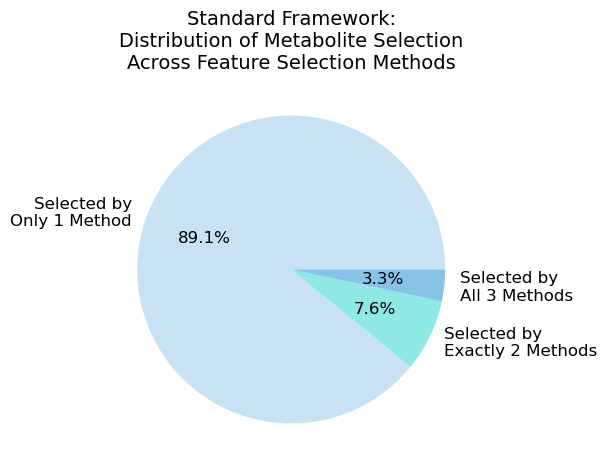

In [78]:
# Plot pie chart
labels = ['Selected by\nOnly 1 Method', 'Selected by\nExactly 2 Methods', 'Selected by\nAll 3 Methods']
sizes = [len(only_1), len(only_2), len(all_3)]
colors = ["#c8e2f3", "#90e8e4", "#87c3e6"]

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Standard Framework:\nDistribution of Metabolite Selection\nAcross Feature Selection Methods', fontsize=14)
plt.show()

In [79]:
# Get feature importance from models
df_lasso_featImport = pd.DataFrame({
    "Metabolite": X_train_lasso.columns,
    "Importance": lasso_rf_model.feature_importances_,
    "in_lasso": True
})

df_hsic_featImport = pd.DataFrame({
    "Metabolite": X_train_hsic.columns,
    "Importance": hsic_rf_model.feature_importances_,
    "in_hsic": True
})

df_intersect_featImport = pd.DataFrame({
    "Metabolite": X_train_intersect.columns,
    "Importance": intersect_rf_model.feature_importances_,
    "in_intersect": True
})

In [80]:
# Merge all into one DataFrame
df_feature_importance = pd.concat([df_lasso_featImport, df_hsic_featImport, df_intersect_featImport], ignore_index=True)

# Group by metabolite and aggregate
df_feature_importance = df_feature_importance.groupby("Metabolite").agg({
    "Importance": "mean",
    "in_lasso": "max",
    "in_hsic": "max",
    "in_intersect": "max"
}).reset_index()

display(df_feature_importance)

,Metabolite,Importance,in_lasso,in_hsic,in_intersect
0,NEG.188.0215@3.118352,0.036819,True,True,True
1,NEG.260.0227@3.1177266,0.015267,True,NaN,NaN
2,NEG.264.0319@3.1174238,0.017956,True,NaN,NaN
3,NEG.417.0821@7.376877,0.006794,True,NaN,NaN
4,NEG.499.0904@5.579267,0.034471,True,True,True
5,NEG.531.9692@3.1188157,0.015081,True,NaN,NaN
6,NEG.552.1128@5.579016,0.070751,True,NaN,NaN
7,NEG.558.1297@5.5803638,0.025613,True,NaN,NaN
8,NEG.621.4177@7.413963,0.016205,True,NaN,NaN
9,NEG.654.4381@7.465804,0.019681,True,True,True


In [81]:
# Estimate method_count
df_feature_importance["method_count"] = df_feature_importance[["in_lasso", "in_hsic", "in_intersect"]].sum(axis=1)

# Proportional split
df_feature_importance["lasso_part"] = df_feature_importance["Importance"] * df_feature_importance["in_lasso"] / df_feature_importance["method_count"]
df_feature_importance["hsic_part"] = df_feature_importance["Importance"] * df_feature_importance["in_hsic"] / df_feature_importance["method_count"]
df_feature_importance["intersect_part"] = df_feature_importance["Importance"] * df_feature_importance["in_intersect"] / df_feature_importance["method_count"]

df_feature_importance["lasso_part"] = df_feature_importance["lasso_part"].astype(float)
df_feature_importance["hsic_part"] = df_feature_importance["hsic_part"].astype(float)
df_feature_importance["intersect_part"] = df_feature_importance["intersect_part"].astype(float)

display(df_feature_importance)

,Metabolite,Importance,in_lasso,in_hsic,in_intersect,method_count,lasso_part,hsic_part,intersect_part
0,NEG.188.0215@3.118352,0.036819,True,True,True,3,0.012273,0.012273,0.012273
1,NEG.260.0227@3.1177266,0.015267,True,NaN,NaN,1,0.015267,NaN,NaN
2,NEG.264.0319@3.1174238,0.017956,True,NaN,NaN,1,0.017956,NaN,NaN
3,NEG.417.0821@7.376877,0.006794,True,NaN,NaN,1,0.006794,NaN,NaN
4,NEG.499.0904@5.579267,0.034471,True,True,True,3,0.011490,0.011490,0.011490
5,NEG.531.9692@3.1188157,0.015081,True,NaN,NaN,1,0.015081,NaN,NaN
6,NEG.552.1128@5.579016,0.070751,True,NaN,NaN,1,0.070751,NaN,NaN
7,NEG.558.1297@5.5803638,0.025613,True,NaN,NaN,1,0.025613,NaN,NaN
8,NEG.621.4177@7.413963,0.016205,True,NaN,NaN,1,0.016205,NaN,NaN
9,NEG.654.4381@7.465804,0.019681,True,True,True,3,0.006560,0.006560,0.006560


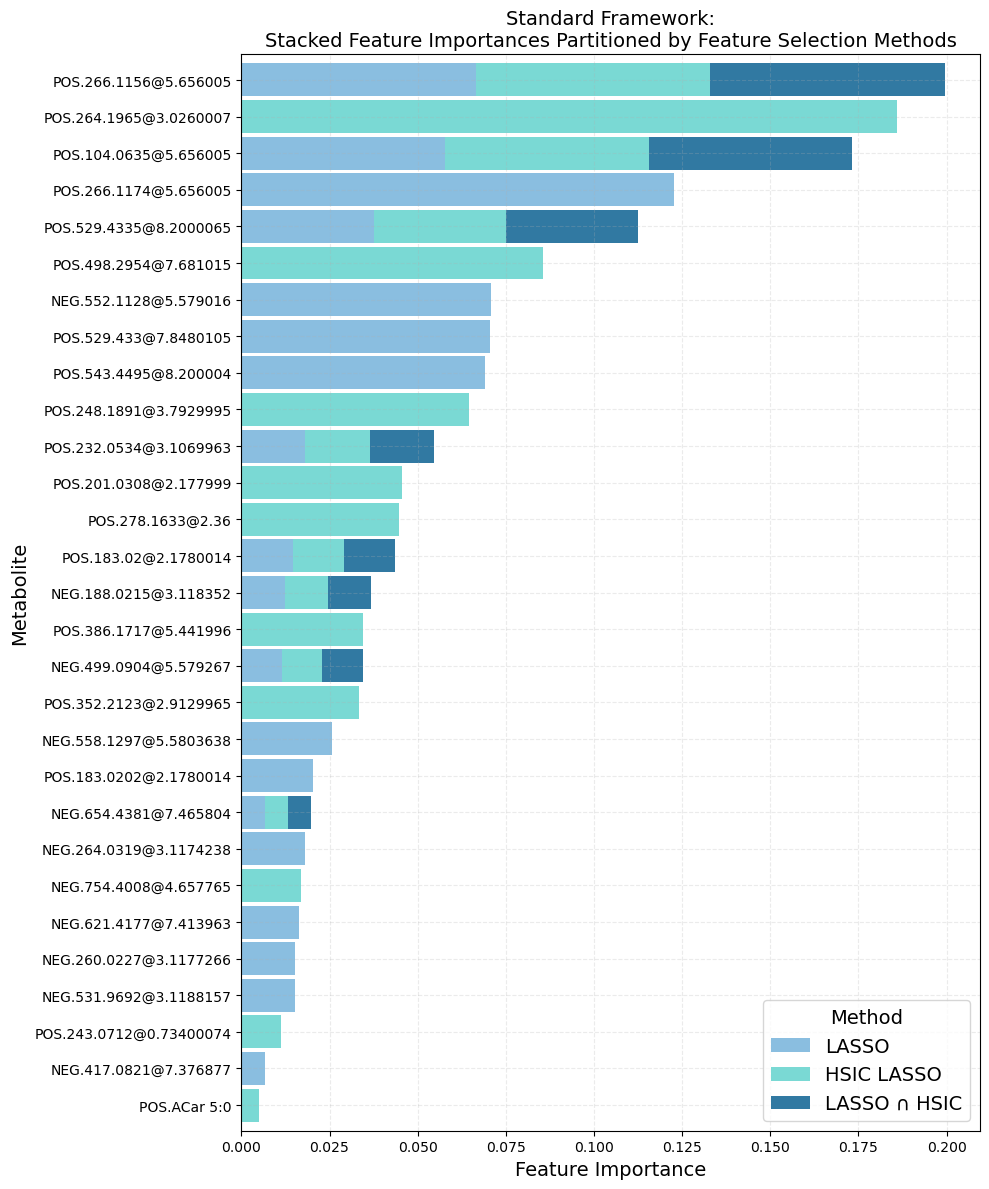

In [89]:
# Prepare for stacked bar
df_plot = df_feature_importance.set_index("Metabolite")[["lasso_part", "hsic_part", "intersect_part"]]
df_plot["Total_Importance"] = df_plot.sum(axis=1)
df_plot = df_plot.sort_values(by="Total_Importance", ascending=False).iloc[::-1]
df_plot = df_plot.drop(columns="Total_Importance")

# Plot
fig, ax = plt.subplots(figsize=(10, 12))

df_plot.plot(kind="barh", stacked=True, ax=ax,
             color=["#8abee0", "#7ad9d4", "#3179a2"], width=0.9)

ax.set_title("Standard Framework:\nStacked Feature Importances Partitioned by Feature Selection Methods", fontsize=14)
ax.set_xlabel("Feature Importance", fontsize=14)
ax.set_ylabel("Metabolite", fontsize=14)
ax.legend(["LASSO", "HSIC LASSO", "LASSO \u2229 HSIC"], title="Method", fontsize=14, title_fontsize=14)
ax.grid(True, linestyle='--', alpha=0.25)

plt.tight_layout()
plt.show()

# Model Comparison

## Import Libraries

In [83]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Feature Importance

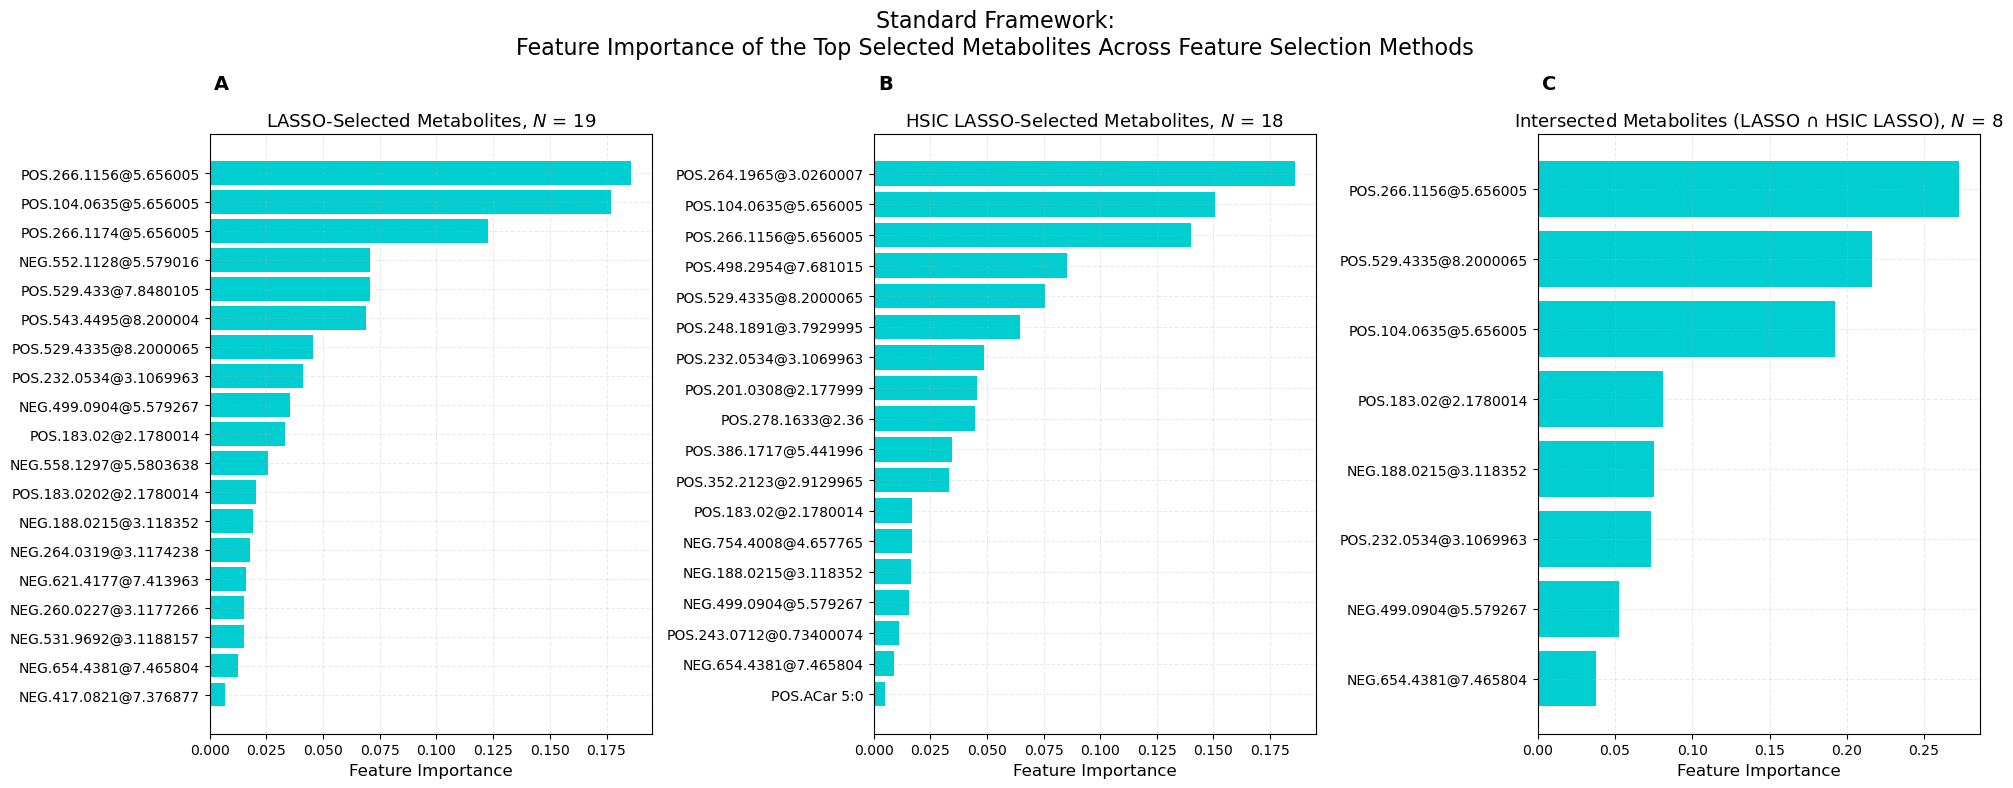

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# Plot LASSO
importances = lasso_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = X_train_lasso.columns[indices]

ax[0].barh(features_sorted[::-1], importances[indices][::-1], color='darkturquoise')
ax[0].set_xlabel("Feature Importance", fontsize=12)
ax[0].set_title(f"LASSO-Selected Metabolites, $N$ = {len(importances)}", fontsize=13)
ax[0].grid(True, linestyle='--', alpha=0.25)
ax[0].text(0.01, 1.1, 'A', transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top')

# Plot HSIC Lasso
importances = hsic_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = X_train_hsic.columns[indices]

ax[1].barh(features_sorted[::-1], importances[indices][::-1], color='darkturquoise')
ax[1].set_xlabel("Feature Importance", fontsize=12)
ax[1].set_title(f"HSIC LASSO-Selected Metabolites, $N$ = {len(importances)}", fontsize=13)
ax[1].grid(True, linestyle='--', alpha=0.25)
ax[1].text(0.01, 1.1, 'B', transform=ax[1].transAxes, fontsize=14, fontweight='bold', va='top')

# Plot intersected
importances = intersect_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = X_train_intersect.columns[indices]

ax[2].barh(features_sorted[::-1], importances[indices][::-1], color='darkturquoise')
ax[2].set_xlabel("Feature Importance", fontsize=12)
ax[2].set_title(f"Intersected Metabolites (LASSO \u2229 HSIC LASSO), $N$ = {len(importances)}", fontsize=13)
ax[2].grid(True, linestyle='--', alpha=0.25)
ax[2].text(0.01, 1.1, 'C', transform=ax[2].transAxes, fontsize=14, fontweight='bold', va='top')

plt.suptitle("Standard Framework:\nFeature Importance of the Top Selected Metabolites Across Feature Selection Methods", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## Confusion Matrices

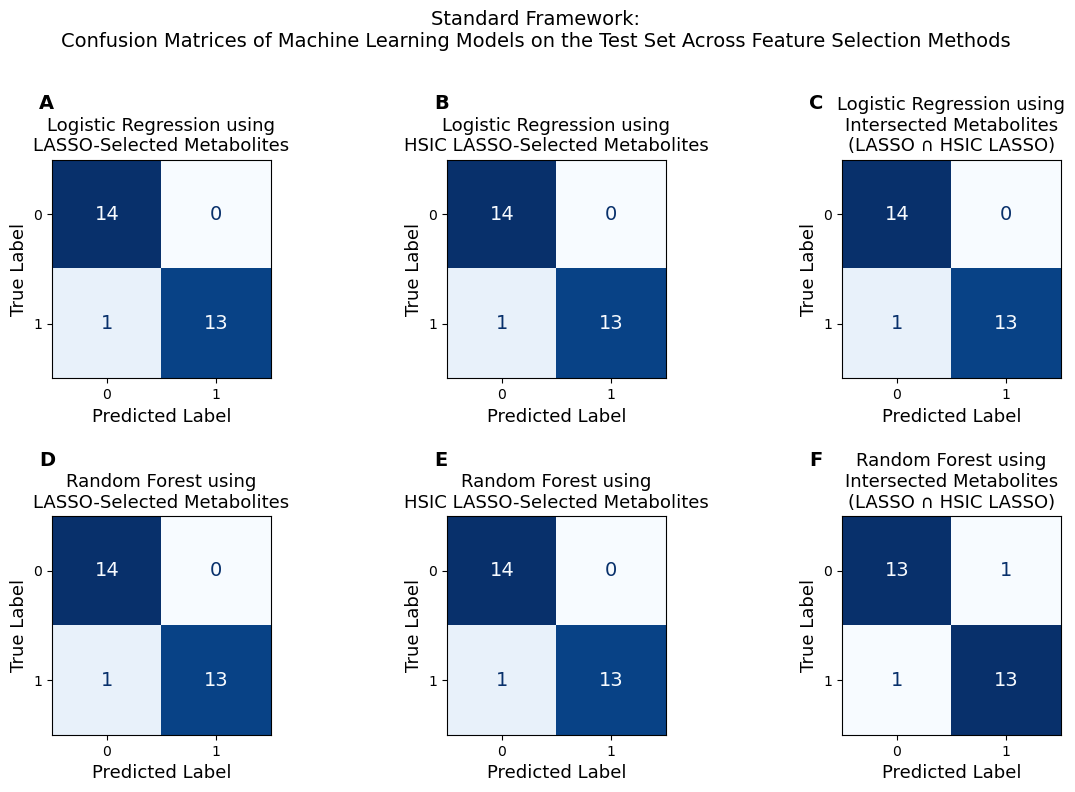

In [85]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ConfusionMatrixDisplay.from_estimator(lasso_logReg_model, X_test_lasso, y_test, cmap='Blues', ax=ax[0,0], colorbar=False)
ax[0,0].set_title("Logistic Regression using\nLASSO-Selected Metabolites", fontsize=13)
ax[0,0].set_xlabel("Predicted Label", fontsize=13)
ax[0,0].set_ylabel("True Label", fontsize=13)
ax[0,0].text(-0.06, 1.3, 'A', transform=ax[0,0].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(hsic_logReg_model, X_test_hsic, y_test, cmap='Blues', ax=ax[0,1], colorbar=False)
ax[0,1].set_title("Logistic Regression using\nHSIC LASSO-Selected Metabolites", fontsize=13)
ax[0,1].set_xlabel("Predicted Label", fontsize=13)
ax[0,1].set_ylabel("True Label", fontsize=13)
ax[0,1].text(-0.06, 1.3, 'B', transform=ax[0,1].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(intersect_logReg_model, X_test_intersect, y_test, cmap='Blues', ax=ax[0,2], colorbar=False)
ax[0,2].set_title("Logistic Regression using\nIntersected Metabolites\n(LASSO \u2229 HSIC LASSO)", fontsize=13)
ax[0,2].set_xlabel("Predicted Label", fontsize=13)
ax[0,2].set_ylabel("True Label", fontsize=13)
ax[0,2].text(-0.15, 1.3, 'C', transform=ax[0,2].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(lasso_rf_model, X_test_lasso, y_test, cmap='Blues', ax=ax[1,0], colorbar=False)
ax[1,0].set_title("Random Forest using\nLASSO-Selected Metabolites", fontsize=13)
ax[1,0].set_xlabel("Predicted Label", fontsize=13)
ax[1,0].set_ylabel("True Label", fontsize=13)
ax[1,0].text(-0.06, 1.3, 'D', transform=ax[1,0].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(hsic_rf_model, X_test_hsic, y_test, cmap='Blues', ax=ax[1,1], colorbar=False)
ax[1,1].set_title("Random Forest using\nHSIC LASSO-Selected Metabolites", fontsize=13)
ax[1,1].set_xlabel("Predicted Label", fontsize=13)
ax[1,1].set_ylabel("True Label", fontsize=13)
ax[1,1].text(-0.06, 1.3, 'E', transform=ax[1,1].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(intersect_rf_model, X_test_intersect, y_test, cmap='Blues', ax=ax[1,2], colorbar=False)
ax[1,2].set_title("Random Forest using\nIntersected Metabolites\n(LASSO \u2229 HSIC LASSO)", fontsize=13)
ax[1,2].set_xlabel("Predicted Label", fontsize=13)
ax[1,2].set_ylabel("True Label", fontsize=13)
ax[1,2].text(-0.15, 1.3, 'F', transform=ax[1,2].transAxes, fontsize=13, fontweight='bold', va='top')

# Set font size of the cell values inside all confusion matrices
for row in ax:
    for a in row:
        for text in a.texts:
            text.set_fontsize(14)

plt.suptitle("Standard Framework:\nConfusion Matrices of Machine Learning Models on the Test Set Across Feature Selection Methods", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Receiver Operating Characteristic (ROC) Curves

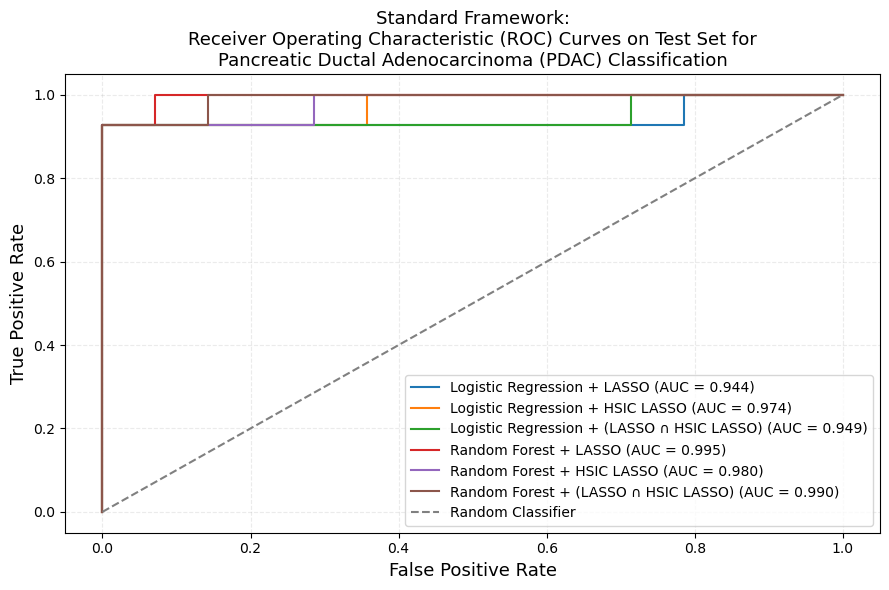

In [92]:
plt.figure(figsize=(9, 6))

# Logistic Regression (LASSO)
y_prob_lasso_lg = lasso_logReg_model.predict_proba(X_test_lasso)[:, 1]
fpr_lasso_lg, tpr_lasso_lg, _ = roc_curve(y_test, y_prob_lasso_lg)
auc_lasso_lg = auc(fpr_lasso_lg, tpr_lasso_lg)
plt.plot(fpr_lasso_lg, tpr_lasso_lg, label=f"Logistic Regression + LASSO (AUC = {auc_lasso_lg:.3f})")

# Logistic Regression (HSIC)
y_prob_hsic_lg = hsic_logReg_model.predict_proba(X_test_hsic)[:, 1]
fpr_hsic_lg, tpr_hsic_lg, _ = roc_curve(y_test, y_prob_hsic_lg)
auc_hsic_lg = auc(fpr_hsic_lg, tpr_hsic_lg)
plt.plot(fpr_hsic_lg, tpr_hsic_lg, label=f"Logistic Regression + HSIC LASSO (AUC = {auc_hsic_lg:.3f})")

# Logistic Regression (LASSO-HSIC)
y_prob_intersect_lg = intersect_logReg_model.predict_proba(X_test_intersect)[:, 1]
fpr_intersect_lg, tpr_intersect_lg, _ = roc_curve(y_test, y_prob_intersect_lg)
auc_intersect_lg = auc(fpr_intersect_lg, tpr_intersect_lg)
plt.plot(fpr_intersect_lg, tpr_intersect_lg, label=f"Logistic Regression + (LASSO \u2229 HSIC LASSO) (AUC = {auc_intersect_lg:.3f})")

# Random Forest (LASSO)
y_prob_lasso_rf = lasso_rf_model.predict_proba(X_test_lasso)[:, 1]
fpr_lasso_rf, tpr_lasso_rf, _ = roc_curve(y_test, y_prob_lasso_rf)
auc_lasso_rf = auc(fpr_lasso_rf, tpr_lasso_rf)
plt.plot(fpr_lasso_rf, tpr_lasso_rf, label=f"Random Forest + LASSO (AUC = {auc_lasso_rf:.3f})")

# Random Forest (HSIC)
y_prob_hsic_rf = hsic_rf_model.predict_proba(X_test_hsic)[:, 1]
fpr_hsic_rf, tpr_hsic_rf, _ = roc_curve(y_test, y_prob_hsic_rf)
auc_hsic_rf = auc(fpr_hsic_rf, tpr_hsic_rf)
plt.plot(fpr_hsic_rf, tpr_hsic_rf, label=f"Random Forest + HSIC LASSO (AUC = {auc_hsic_rf:.3f})")

# Random Forest (LASSO-HSIC)
y_prob_intersect_rf = intersect_rf_model.predict_proba(X_test_intersect)[:, 1]
fpr_intersect_rf, tpr_intersect_rf, _ = roc_curve(y_test, y_prob_intersect_rf)
auc_intersect_rf = auc(fpr_intersect_rf, tpr_intersect_rf)
plt.plot(fpr_intersect_rf, tpr_intersect_rf, label=f"Random Forest + (LASSO \u2229 HSIC LASSO) (AUC = {auc_intersect_rf:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("Standard Framework:\nReceiver Operating Characteristic (ROC) Curves on Test Set for\nPancreatic Ductal Adenocarcinoma (PDAC) Classification", fontsize=13)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.25)
plt.tight_layout()
plt.show()